In [1]:
# Phase 3: Cluster Insights and Business Recommendations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

# Load RFM data with cluster labels
rfm = pd.read_csv("../data/rfm_with_clusters.csv")

print("RFM with clusters loaded. Shape:", rfm.shape)
rfm.head()


RFM with clusters loaded. Shape: (4718, 5)


,customerno,recency,frequency,monetary,cluster
0,12004.0,228,1,1509.60,1
1,12006.0,219,1,24.76,1
2,12008.0,277,1,5689.57,1
3,12013.0,360,1,69.96,1
4,12024.0,177,1,149.52,1


In [2]:
#Compute KPIs for each cluster

# Calculate total revenue to compute revenue share later
total_revenue = rfm["monetary"].sum()

# Compute core metrics per cluster

cluster_kpis = (
    rfm.groupby("cluster")
      .agg(
          customers=("cluster", "size"),
          avg_recency=("recency", "mean"),
          avg_frequency=("frequency", "mean"),
          avg_monetary=("monetary", "mean"),
          total_revenue=("monetary", "sum")
      )
      .assign(
          revenue_share=lambda d: 100 * d["total_revenue"] / total_revenue,
          avg_order_value=lambda d: d["avg_monetary"] / (d["avg_frequency"] + 1e-9)
      )
      .round(2)
      .sort_values("revenue_share", ascending=False)
)

print("Cluster-level KPIs calculated successfully.")
cluster_kpis


Cluster-level KPIs calculated successfully.


,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,revenue_share,avg_order_value
cluster,,,,,,,
2,932,15.55,12.11,43338.15,40391154.02,64.15,3579.51
3,1408,97.49,3.25,11777.30,16582435.55,26.34,3622.99
0,969,20.18,2.27,3674.57,3560654.16,5.65,1618.48
1,1409,203.20,1.23,1725.80,2431648.61,3.86,1407.20


In [3]:
#Interpret and label clusters

# Define basic interpretation rules
def label_cluster(row):
    if row["avg_recency"] < 30 and row["avg_frequency"] > 10 and row["avg_monetary"] > 20000:
        return "High-Value Active Customers"
    elif row["avg_recency"] < 60 and row["avg_frequency"] >= 3:
        return "Loyal Customers"
    elif row["avg_recency"] < 120 and row["avg_frequency"] <= 3:
        return "At-Risk or Occasional Buyers"
    else:
        return "Lost or Inactive Customers"

# Apply labeling
cluster_kpis["segment_label"] = cluster_kpis.apply(label_cluster, axis=1)

# Reorder columns for clarity
cluster_kpis = cluster_kpis[
    ["customers", "avg_recency", "avg_frequency", "avg_monetary", 
     "revenue_share", "avg_order_value", "segment_label"]
]

print("Cluster labeling completed.\n")
cluster_kpis
#useful for next step

Cluster labeling completed.



,customers,avg_recency,avg_frequency,avg_monetary,revenue_share,avg_order_value,segment_label
cluster,,,,,,,
2,932,15.55,12.11,43338.15,64.15,3579.51,High-Value Active Customers
3,1408,97.49,3.25,11777.30,26.34,3622.99,Lost or Inactive Customers
0,969,20.18,2.27,3674.57,5.65,1618.48,At-Risk or Occasional Buyers
1,1409,203.20,1.23,1725.80,3.86,1407.20,Lost or Inactive Customers


Number of customers in each cluster:
cluster
0     969
1    1409
2     932
3    1408
Name: count, dtype: int64


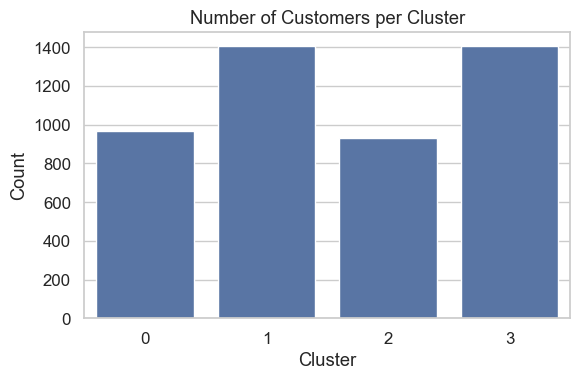

In [4]:
#Cluster size distribution

cluster_counts = rfm["cluster"].value_counts().sort_index()

print("Number of customers in each cluster:")
print(cluster_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [5]:
#Statistical validation (ANOVA) to check if clusters differ significantly

from scipy.stats import f_oneway

features = ["recency", "frequency", "monetary"]

for feature in features:
    groups = [rfm[rfm["cluster"] == c][feature] for c in sorted(rfm["cluster"].unique())]
    f_val, p_val = f_oneway(*groups)
    print(f"{feature}: F-statistic = {f_val:.2f}, p-value = {p_val:.6f}")


recency: F-statistic = 2074.66, p-value = 0.000000
frequency: F-statistic = 651.28, p-value = 0.000000
monetary: F-statistic = 137.45, p-value = 0.000000


**Interpretation:**  
Since all p-values are less than 0.05, we can conclude that there are statistically significant differences between clusters in terms of Recency, Frequency, and Monetary values.  
This confirms that the clustering algorithm has successfully created distinct customer groups.


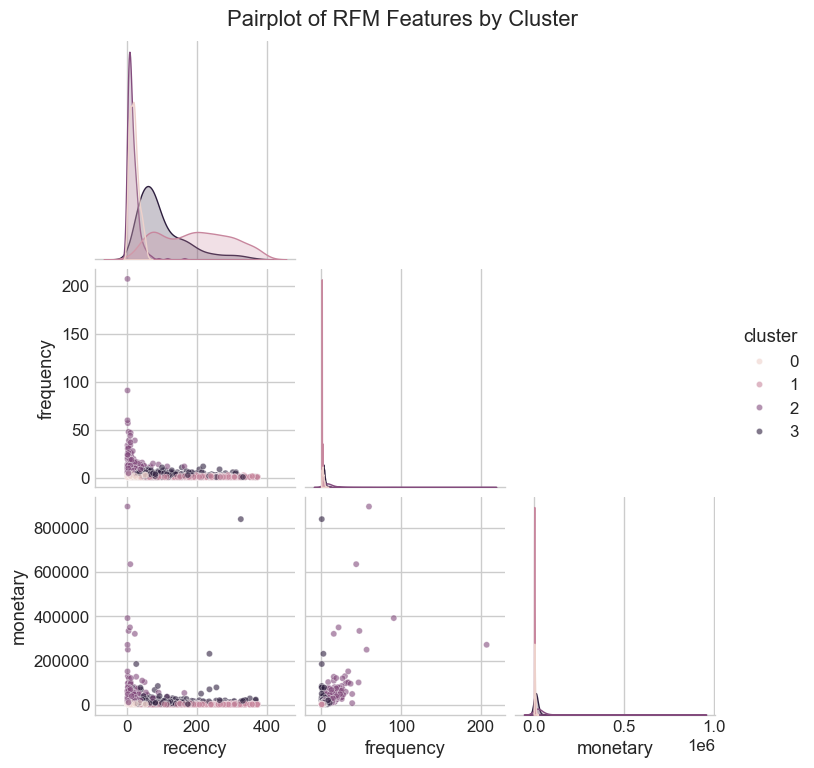

In [7]:
# extra    Visual inspection of cluster separation in RFM space

sample_size = min(2000, len(rfm))
rfm_sample = rfm.sample(sample_size, random_state=42)

sns.pairplot(
    rfm_sample,
    vars=["recency", "frequency", "monetary"],
    hue="cluster",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 20}
)
plt.suptitle("Pairplot of RFM Features by Cluster", y=1.02)
plt.show()


**Interpretation:**  
The pairplot visualizes the distribution and pairwise relationships of Recency, Frequency, and Monetary values across clusters.  
It shows that clusters are relatively well separated, particularly along the Monetary and Recency dimensions.  
Cluster 2 appears to contain high-value customers (high Monetary, low Recency),  
while Cluster 1 represents less active customers with high Recency and low Frequency.  
Although some overlap exists, the clusters display distinct behavioral patterns,  
supporting the validity of the segmentation.


C:\Users\Mehrshad\AppData\Local\Temp\ipykernel_3420\1121638142.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_kpis.index, y="avg_recency", data=cluster_kpis, ax=axes[0], palette="crest")
C:\Users\Mehrshad\AppData\Local\Temp\ipykernel_3420\1121638142.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_kpis.index, y="avg_frequency", data=cluster_kpis, ax=axes[1], palette="flare")
C:\Users\Mehrshad\AppData\Local\Temp\ipykernel_3420\1121638142.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_kpis.index, y

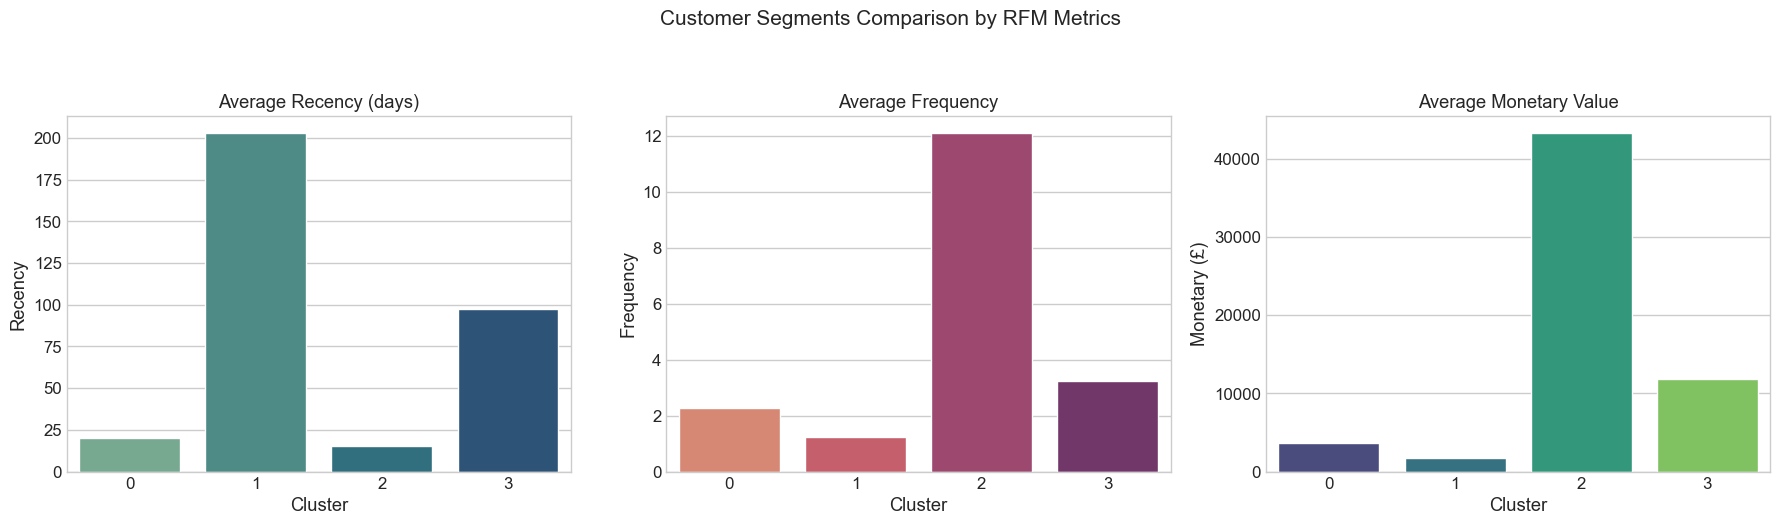

In [6]:
#Visualization of Cluster Insights

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency comparison
sns.barplot(x=cluster_kpis.index, y="avg_recency", data=cluster_kpis, ax=axes[0], palette="crest")
axes[0].set_title("Average Recency (days)")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Recency")

# Frequency comparison
sns.barplot(x=cluster_kpis.index, y="avg_frequency", data=cluster_kpis, ax=axes[1], palette="flare")
axes[1].set_title("Average Frequency")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Frequency")

# Monetary comparison
sns.barplot(x=cluster_kpis.index, y="avg_monetary", data=cluster_kpis, ax=axes[2], palette="viridis")
axes[2].set_title("Average Monetary Value")
axes[2].set_xlabel("Cluster")
axes[2].set_ylabel("Monetary (£)")

plt.suptitle("Customer Segments Comparison by RFM Metrics", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()


## Phase 3 – Cluster Insights Summary

Based on the RFM-based clustering, we identified four distinct customer segments:

**High-Value Active Customers (Cluster 2)**: Very recent, very frequent, and extremely high monetary value; responsible for the majority of total revenue.
**Loyal Customers (Cluster 3)**: Regular buyers with moderate frequency and strong spending; important for stable revenue.
**At-Risk or Occasional Buyers (Cluster 0)**: More recent than fully lost customers but with low frequency and limited monetary value.
**Lost or Inactive Customers (Cluster 1)**: Long time since last purchase, very low frequency and spend; primary target for win-back or can be deprioritized.

**Note:** ANOVA and Value Score were used to validate and rank the clusters.


These insights will be used in Phase 4 to design targeted marketing strategies for each segment.
